In [42]:
import os, sys, math, importlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import layers as tfl
import tensorflow_io as tfio
import tensorflow_datasets as tfds

#import skimage.transform as trans
#import cv_image_proc

#tf.config.run_functions_eagerly(True) # this is needed for debugging!!!
#tf.data.experimental.enable_debug_mode() # eager execution of tf.data functions

print(f"Function exec eagerly: {tf.executing_eagerly()}")
print(tf.config.list_physical_devices('GPU'))
print(f"Tensorflow version: {tf.__version__} tf io: {tfio.__version__}")

# 1. VCF Model: An integrated neural network model for pupil detection and tracking
# https://github.com/UnderTheMangoTree/LVCF
# 2. DeepVOG: Open-source pupil segmentation and gaze estimation in neuroscience using deep learning
# this is based on UNET architecture
# https://github.com/pydsgz/DeepVOG
# 3. DeepEye: Deep convolutional network for pupil detection in real environments 
# this is based on ASPP (atrous convs), similar to DeepLabv3: https://github.com/leimao/DeepLab-V3
# https://github.com/Fjaviervera/DeepEye

Function exec eagerly: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version: 2.10.1 tf io: 0.26.0


In [43]:
import common
importlib.reload(common)
from common import *
from enum import IntEnum

# this prepares the main data set by parsing files, could take long
#NAS_dir = "Y:/Schwind/Titan/FeldTest_SW1.2/original/"
base_dir = "C:/SchwindResource/FieldTest/"
csv_set = tf.data.Dataset.list_files(base_dir + "Vid*.csv")
origSize = (800,800)
croppedSize, scaleFactor = (512,512), 2
cropFactor = float(croppedSize[0]) / origSize[0] # central crop factor to reduce image size.. 
ofsX, ofsY = float(origSize[0] - croppedSize[0])/scaleFactor, float(origSize[1] - croppedSize[1])/scaleFactor
imageShape = (256,256,1) # this is basically croppedSize/scaleFactor

#vidFile = NAS_dir + "20210519/Patient1/2021-05-14__08-46-05__13388512_SUNJO_Graciela_OD.Cam1VID._TiCam1_210514_084605.avi"
#zz = tfio.IODataset.from_ffmpeg(", #               "v:0")
#vid = tfio.experimental.ffmpeg.decode_video(vidFile, "0")

class CSV(IntEnum):
    FName = 0  
    FrameNo = 1 
    EyeCode = 2
    PupilQ = 3
    PupilX = 4
    PupilY = 5
    PupilR = 6

def loadByFrameNo(*csv):
    frameS = tf.strings.as_string(csv[CSV.FrameNo], width=6, fill='0')
    name = csv[CSV.FName] + frameS + '.png'
    bytes = tf.io.read_file(name)
    image = tf.io.decode_png(bytes)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image =  tf.image.central_crop(image, cropFactor)
    Q, X, Y, R = csv[CSV.PupilQ:]
    #Q = 0.0 if Q < 30 else 1.0 # map to 0-1 range
    img = tf.image.resize(image, imageShape[:-1])
    img -= tf.math.reduce_mean(img, keepdims=True)
    img /= (tf.math.reduce_std(img, keepdims=True) + 1e-6)
    #img = img - tf.reduce_mean(img)
    #name += "_Q" + tf.strings.as_string(Q)
    X, Y, R = (X - ofsX)/croppedSize[0], (Y - ofsY)/croppedSize[1], R / croppedSize[0]
    #if Q == 0.0:
    #  X, Y, R = 0.0,0.0,0.0
    # yields image, quality, X, Y, Radius. Quality might be 0 or 1: either image is there or not ?..
    return (img, tf.convert_to_tensor([X, Y, R], dtype=tf.float32)) #, name) 

   # TODO:: use only  very good examles where quality is  close to 100
# FrameNo ; EyeCode ; PupilQ ; PupilX  ; PupilY  ; PupilR ; CycloQ ; Angle  ; PSTValue ; RadStdDev ; AvgGradient ; MaxHoughCenter ; 
csvFields = [str(), int(), str(), int(), float(), float(), float()] #, float(), float(), float(), float(), float(), float()]
def singleCSV(fname):
    # choose only those frames which are OK (eyecode is OK)
    framesDir = tf.strings.regex_replace(fname, '_sim[0-9]+\.csv', '_Frames\\\\scene;')
    # we do not filter over OK field but just skip 3 first records => these are header
    #filter(lambda x: tf.strings.regex_full_match(x, "\d+\s+;\s*OK\s.*"))
    return (tf.data.TextLineDataset(fname).skip(3). 
        map(lambda x: tf.io.decode_csv(tf.strings.join([framesDir,x]), csvFields, field_delim=';', select_cols=[0,1,2,3,4,5,6])). 
        filter(lambda *csv: csv[CSV.PupilQ] >= 90 and csv[CSV.FrameNo] > 50 and csv[CSV.FrameNo] % 13 == 0)) 
        # skip first 20 frames used for white ring detection, and choose every 7th frame



b'C:\\SchwindResource\\FieldTest\\Vid37_2021-07-15__13-47-34__Patient8_Frames\\scene' - 3107; q: 93
b'C:\\SchwindResource\\FieldTest\\Vid31_2021-07-15__11-23-00__Patient2_Frames\\scene' - 2470; q: 95
b'C:\\SchwindResource\\FieldTest\\Vid41_2021-08-02__17-31-05__Patient1_Frames\\scene' - 2379; q: 93
b'C:\\SchwindResource\\FieldTest\\Vid93_2021-09-09__14-23-08__Patient5_Frames\\scene' - 2184; q: 94
b'C:\\SchwindResource\\FieldTest\\Vid28_2021-07-22__13-30-50__Patient8_Frames\\scene' - 2626; q: 90
b'C:\\SchwindResource\\FieldTest\\Vid6_20210625_Frames\\scene' - 4823; q: 93
b'C:\\SchwindResource\\FieldTest\\Vid39_2021-07-15__14-05-08__Patient10_Frames\\scene' - 2275; q: 90
b'C:\\SchwindResource\\FieldTest\\Vid37_2021-07-15__13-47-34__Patient8_Frames\\scene' - 3146; q: 96
b'C:\\SchwindResource\\FieldTest\\Vid31_2021-07-15__11-23-00__Patient2_Frames\\scene' - 2483; q: 94
b'C:\\SchwindResource\\FieldTest\\Vid41_2021-08-02__17-31-05__Patient1_Frames\\scene' - 2392; q: 93
0.438554704 0.45746094

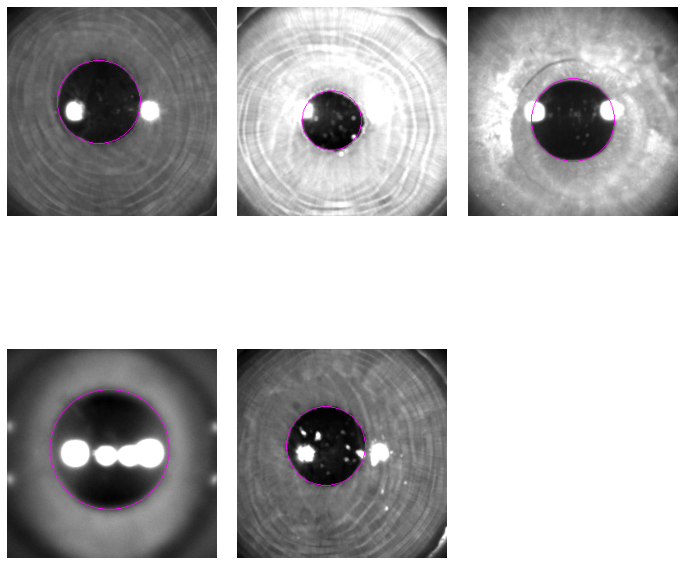

In [44]:
# TODO try tf.keras.utils.image_dataset_from_directory
fullDS = csv_set.interleave(singleCSV) #.shuffle(buffer_size=5000)
# shuffle csv data before loading images..
# better shuffle the filenames directly before loading image data
# shuffle().repeat(): "1 3 2, 1 3 2, 1 3 2" or "3 1 2, 3 1 2, 3 1 2"
for (name,frameNo,OK,q,x,y,R) in fullDS.take(10):   
     print(f"{name.numpy()} - {frameNo.numpy()}; q: {q}")

fullDS = fullDS.map(loadByFrameNo)
displayDS(fullDS, 5, lambda img,bbox : drawCircleImg(img, bbox))

In [41]:
import Segmentation, EfficientNet, NN_Blocks
importlib.reload(Segmentation)
importlib.reload(EfficientNet)
importlib.reload(NN_Blocks)
#from EfficientNet import *
from enum import IntEnum

TEST_SZ = 1000
VALID_SZ = 1000
TRAIN_LENGTH = 11111 #info.splits['train'].num_examples
BATCH_SIZE = 4
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# compute radiuses, X and Y
#sum,num = fullDS.reduce((tf.zeros(3, tf.float32), 0.0), lambda s,item : (s[0] + item[1], s[1] + 1))
#print("result: ",sum,num,sum/num)

train_batches = (fullDS
     .cache()
     .batch(BATCH_SIZE)
     .repeat()
     #.map(Augment())
     .prefetch(buffer_size=tf.data.AUTOTUNE))
#tfds.benchmark(train_batches, batch_size=BATCH_SIZE)
  
testS = fullDS.take(TEST_SZ) 
validS = fullDS.skip(TEST_SZ).take(VALID_SZ)   
trainS = fullDS.skip(TEST_SZ + VALID_SZ)  

inputs = tfl.Input(shape=imageShape)

# input filters: 96, output filters: 24
# can also do usual VGG block as: vgg_r5_k3_o32_bn
# and for mbconv: mb_r5_k3...
block_string = ['r3_k3_s22_e6_i16_o24_se0.25']
global_args = EfficientNet.GlobalParams(
      batch_norm_momentum=0.99,
      batch_norm_epsilon=1e-3,
      dropout_rate=0.2,
      survival_prob=0.8,
      relu_fn=tf.nn.swish,
      use_se=True,
      clip_projection_output=False)

#M = EfficientNet.ModelGenerator(global_args, block_string)
inputs = tfl.Input(shape=(256,256,1))
#Z = Segmentation.UNet()(inputs)

numFlts = 32
useBN=True
X = NN_Blocks.conv_block(inputs, numFlts, useBN=useBN)
X = NN_Blocks.vgg_block(X, numFlts, num_convs=3, kernel_size=3, useBN=useBN)
X = NN_Blocks.vgg_block(X, numFlts*2, num_convs=3, kernel_size=3, useBN=useBN)
X = NN_Blocks.vgg_block(X, numFlts*4, num_convs=3, kernel_size=3, useBN=useBN)
X = NN_Blocks.vgg_block(X, numFlts*8, num_convs=3, kernel_size=3, useBN=useBN)

M = tf.keras.Model(inputs=inputs,outputs=X)
#M.summary()
DM = Segmentation.DeepLabv3Plus(M, downscale_factors=[4,4], num_filters=128, dilation_rates=[6,12,18], relu_fn='relu')

#for L in reversed(M.layers[:-1]):
 #     print(L.name, L.output.shape)

#displayModel(DM)
#MM.build(input_shape=(1,256,256,1))
#MM.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#MM.summary()



In [ ]:
try:
  model.fit(train_batches, epochs=20, steps_per_epoch=300)
  #model_history = model.fit(train_batches, epochs=EPOCHS,
                         #  steps_per_epoch=STEPS_PER_EPOCH,
                         #  validation_steps=VALIDATION_STEPS,
                         #  validation_data=test_batches,
                         #  callbacks=[DisplayCallback()])
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

truth=7.306789617800291e-10, mine: nan


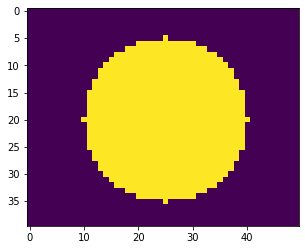

In [140]:
#imageList = list(iter(fullDS.skip(10).take(10)))
#displayDS(imageList, len(imageList), drawCircleImg)

#zz = zz.reshape(zz.shape[1:])
#yy = np.asarray(zz)
#print(yy.ndim)
#plt.imshow([aa,zz], cmap='gray')

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO)
#displayDS(imageList, len(imageList), drawCircleImg)

def BCELogits(y_true, y_pred, fromLogits=False):
    eps = 1e-7
    y_probs = K.sigmoid(y_pred) if fromLogits else y_pred
    bce = y_true * tf.math.log(y_probs + eps)
    #print(f"bce = {bce}, probs = {1 - y_probs + eps}")
    # or use tf.math.log1p
    bce += (1 - y_true) * tf.math.log(1 - y_probs + eps)
    #print(f"bce before reduce: {bce}")
    bce = tf.reduce_mean(bce)
    return -bce

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO)
tf.random.set_seed(5)
w,h,R = 50,40,15

shape=[1,h,w,1]
y_true=np.ones(shape, np.float32) #tf.random.uniform(shape=shape,minval=0,maxval=1)
y_pred=np.ones(shape, np.float32) #tf.random.uniform(shape=shape,minval=-5,maxval=5)
y_pred *= 20
y_pred[:,0:2,:,:] = -20 # set one vertical line and one horizontal to zero prob
y_pred[:,:,0:2,:] = -20

cy,cx = h/2,w/2
Y,X = np.ogrid[0:h,0:w]
distSq = np.square(X - cx) + np.square(Y - cy)
maskC = tf.cast(distSq <= R*R, tf.float32)
plt.imshow(maskC)

maskC = tf.expand_dims(maskC,axis=0)
# without masking, loss would be quite large
truth = bce(y_true,y_pred,sample_weight=maskC)
print(f"truth={truth}, mine: {BCELogits(y_true,y_pred).numpy()}")


In [ ]:
UU = tf.stack([img for img,pup in imageList], axis=0)
print(UU.shape)

inp = model.input                                           # input placeholder
outputs = [layer.output for i,layer in enumerate(model.layers) if i > 40]          # all layer outputs
Xmodel = keras.Model(inputs=model.input, outputs=outputs)
pup = model.predict(UU)

displayDS(zip(imageList, pup), len(imageList), lambda img,X: drawCircleImg(img[0],X))
